In [227]:
from keras.models import Model
from keras.layers import LSTM, Input, Dense, Activation, Add, Reshape, Lambda, Concatenate, \
                         TimeDistributed, Bidirectional, Masking
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from keras.models import load_model

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [159]:
from collections import Counter

In [2]:
from corpus import *
from sklearn.utils import shuffle

In [3]:
corpus = MTCorpus()

In [233]:
docs, links = shuffle(corpus.documents, corpus.links, random_state=0)
assert len([i for l in links for i in l]) == sum((len(d) for d in docs))

In [235]:
np.where(np.array([len(d) for d in docs]) > 6)

(array([42, 48, 73]),)

In [280]:
# pad with zeros, truncate longer than 6
X = pad_sequences(docs, dtype=float, maxlen=6, truncating='post',padding='post')

# convert links 1,1,2 -> [1,0,0]
#                        [1,0,0]
#                        [0,1,0]
Y = np.array([to_categorical(np.array(y)[:7]-1, num_classes=X.shape[1]) for y in links])
Y_ind = [len(y) for y in Y]
Y = pad_sequences(Y, dtype=int, maxlen=6,truncating='post', padding='post')

In [257]:
X[10]

array([[-0.10127971,  0.08957867, -0.13523801, ..., -0.06537233,
         0.0309431 ,  0.00880367],
       [ 0.03936228,  0.089379  , -0.14643   , ..., -0.21299562,
         0.03467138,  0.01224762],
       [-0.1085938 ,  0.20812809, -0.11594399, ..., -0.18605158,
         0.08924879,  0.0831376 ],
       [-0.10906823,  0.13407506, -0.13905546, ..., -0.06525046,
        -0.01664981,  0.02541486],
       [ 0.21581212,  0.08725878, -0.11575323, ..., -0.03048111,
        -0.03168344,  0.03684778],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [258]:
Y[10], links[10]

(array([[0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), [3, 3, 3, 5, 3])

In [239]:
X.shape

(112, 6, 300)

Counter({5: 71, 6: 24, 4: 11, 3: 3, 7: 2, 10: 1})


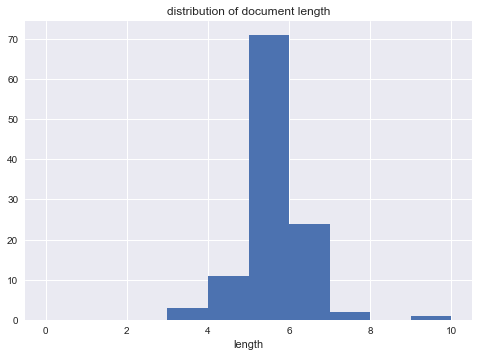

In [240]:
plt.title('distribution of document length')
plt.xlabel('length')
print(Counter([len(d) for d in docs]))
plt.hist([len(d) for d in docs],np.arange(11),);

Counter({1: 259, 3: 96, 5: 76, 2: 55, 4: 51, 6: 37, 7: 1, 9: 1})


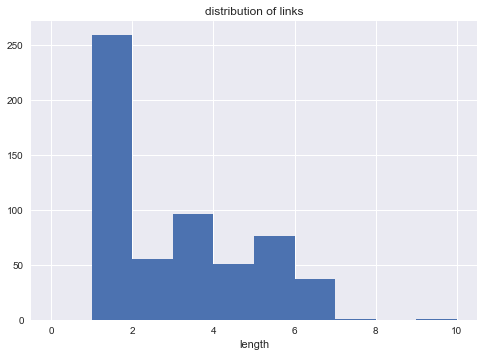

In [241]:
plt.title('distribution of links')
plt.xlabel('length')
print(Counter([i for l in links for i in l]))
plt.hist([i for l in links for i in l],np.arange(11),);

In [242]:
X.shape, Y.shape

((112, 6, 300), (112,))

In [263]:
X_train, Y_train = X[:96], Y[:96]
X_test, Y_test = X[96:], Y[96:]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(96, 6, 300) (96, 6, 6) (16, 6, 300) (16, 6, 6)


In [219]:
hidden_size = 512
seq_len = X.shape[1]
nb_epochs = 4000
batch_size = 16
dropout = .9

In [289]:
inp = Input(shape=(seq_len,300), name='input')

# mask = Masking(mask_value=0., input_shape=(seq_len, 300))(inp)
encoder = Bidirectional(LSTM(hidden_size//2,return_sequences=True, name='encoder', dropout=dropout))(inp)
decoder = LSTM(hidden_size,return_sequences=True, name='decoder', dropout=dropout)(encoder)

# glorot_uniform initializer:
# uniform([-limit,limit]) where limit = sqrt(6/(in+out))
# for hidden=512: uniform(-0.07, +0.07)
E = TimeDistributed(Dense(hidden_size, use_bias=False), name='E')(encoder)
D = TimeDistributed(Dense(hidden_size, use_bias=False), name='D')(decoder)

DD = Lambda(lambda x: K.repeat_elements(K.expand_dims(x, 2), seq_len, 2))(D)

add = Add(name='W1E_W2Di')
tanh = Activation('tanh', name='tanh')

# glorot_uniform initializer:
# uniform([-limit,limit]) where limit = sqrt(6/(in+out))
# for hidden=512: uniform(-0,108, +0,108)
vt = Dense(1, use_bias=False, name='vT')
softmax = Activation('softmax', name='softmax')

attention = add([E,DD])
attention = tanh(attention)
attention = vt(attention)
attention = Lambda(lambda x: K.squeeze(x, -1))(attention)
attention = softmax(attention)

model = Model(inputs=inp, outputs=attention)

In [290]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6, 300)       0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 6, 512)       1140736     input[0][0]                      
__________________________________________________________________________________________________
decoder (LSTM)                  (None, 6, 512)       2099200     bidirectional_11[0][0]           
__________________________________________________________________________________________________
D (TimeDistributed)             (None, 6, 512)       262144      decoder[0][0]                    
__________________________________________________________________________________________________
E (TimeDis

In [275]:
plot_model(model, to_file='model_withoutloop.png')

In [226]:
!open 'model_withoutloop.png'

In [276]:
adam = Adam()
tensorboad = TensorBoard()

In [291]:
print("building model...")

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    epochs=nb_epochs, batch_size=batch_size, verbose=2)
#                     callbacks=[tensorboad])

building model...
Train on 96 samples, validate on 16 samples
Epoch 1/1000
 - 7s - loss: 1.4400 - categorical_accuracy: 0.4444 - val_loss: 1.3770 - val_categorical_accuracy: 0.5521
Epoch 2/1000
 - 1s - loss: 1.4159 - categorical_accuracy: 0.5486 - val_loss: 1.2330 - val_categorical_accuracy: 0.5938
Epoch 3/1000
 - 1s - loss: 1.3245 - categorical_accuracy: 0.5312 - val_loss: 1.1695 - val_categorical_accuracy: 0.5938
Epoch 4/1000
 - 1s - loss: 1.2586 - categorical_accuracy: 0.5469 - val_loss: 1.1326 - val_categorical_accuracy: 0.5938
Epoch 5/1000
 - 1s - loss: 1.1102 - categorical_accuracy: 0.5799 - val_loss: 1.0227 - val_categorical_accuracy: 0.5938
Epoch 6/1000
 - 1s - loss: 1.0308 - categorical_accuracy: 0.6458 - val_loss: 0.9669 - val_categorical_accuracy: 0.5938
Epoch 7/1000
 - 1s - loss: 0.9933 - categorical_accuracy: 0.6059 - val_loss: 0.9043 - val_categorical_accuracy: 0.6042
Epoch 8/1000
 - 1s - loss: 0.9607 - categorical_accuracy: 0.6510 - val_loss: 0.8778 - val_categorical_acc

Epoch 69/1000
 - 1s - loss: 0.5329 - categorical_accuracy: 0.7135 - val_loss: 0.8085 - val_categorical_accuracy: 0.6146
Epoch 70/1000
 - 1s - loss: 0.5527 - categorical_accuracy: 0.7309 - val_loss: 0.8083 - val_categorical_accuracy: 0.5521
Epoch 71/1000
 - 1s - loss: 0.5323 - categorical_accuracy: 0.7517 - val_loss: 0.7702 - val_categorical_accuracy: 0.6042
Epoch 72/1000
 - 1s - loss: 0.5317 - categorical_accuracy: 0.7517 - val_loss: 0.7736 - val_categorical_accuracy: 0.6146
Epoch 73/1000
 - 1s - loss: 0.4752 - categorical_accuracy: 0.7483 - val_loss: 0.8007 - val_categorical_accuracy: 0.5833
Epoch 74/1000
 - 1s - loss: 0.5831 - categorical_accuracy: 0.7240 - val_loss: 0.8127 - val_categorical_accuracy: 0.6354
Epoch 75/1000
 - 1s - loss: 0.5755 - categorical_accuracy: 0.7274 - val_loss: 0.8073 - val_categorical_accuracy: 0.5938
Epoch 76/1000
 - 1s - loss: 0.5122 - categorical_accuracy: 0.7708 - val_loss: 0.7791 - val_categorical_accuracy: 0.5938
Epoch 77/1000
 - 1s - loss: 0.4966 - cat

Epoch 137/1000
 - 1s - loss: 0.2030 - categorical_accuracy: 0.8212 - val_loss: 0.9691 - val_categorical_accuracy: 0.6250
Epoch 138/1000
 - 1s - loss: 0.1886 - categorical_accuracy: 0.8142 - val_loss: 1.0568 - val_categorical_accuracy: 0.5938
Epoch 139/1000
 - 1s - loss: 0.1841 - categorical_accuracy: 0.8038 - val_loss: 0.9896 - val_categorical_accuracy: 0.5938
Epoch 140/1000
 - 1s - loss: 0.1666 - categorical_accuracy: 0.8420 - val_loss: 0.9959 - val_categorical_accuracy: 0.6042
Epoch 141/1000
 - 1s - loss: 0.1990 - categorical_accuracy: 0.8090 - val_loss: 1.0630 - val_categorical_accuracy: 0.5729
Epoch 142/1000
 - 1s - loss: 0.1789 - categorical_accuracy: 0.8247 - val_loss: 1.0686 - val_categorical_accuracy: 0.5729
Epoch 143/1000
 - 1s - loss: 0.1938 - categorical_accuracy: 0.8108 - val_loss: 1.0681 - val_categorical_accuracy: 0.6042
Epoch 144/1000
 - 1s - loss: 0.1381 - categorical_accuracy: 0.8594 - val_loss: 1.0378 - val_categorical_accuracy: 0.6146
Epoch 145/1000
 - 1s - loss: 0.1

Epoch 205/1000
 - 1s - loss: 0.0637 - categorical_accuracy: 0.8819 - val_loss: 1.5174 - val_categorical_accuracy: 0.5625
Epoch 206/1000
 - 1s - loss: 0.0491 - categorical_accuracy: 0.8802 - val_loss: 1.4321 - val_categorical_accuracy: 0.6146
Epoch 207/1000
 - 1s - loss: 0.0697 - categorical_accuracy: 0.8733 - val_loss: 1.5810 - val_categorical_accuracy: 0.6042
Epoch 208/1000
 - 1s - loss: 0.0530 - categorical_accuracy: 0.8767 - val_loss: 1.4150 - val_categorical_accuracy: 0.6042
Epoch 209/1000
 - 1s - loss: 0.0329 - categorical_accuracy: 0.8750 - val_loss: 1.4078 - val_categorical_accuracy: 0.5729
Epoch 210/1000
 - 1s - loss: 0.0537 - categorical_accuracy: 0.8767 - val_loss: 1.4191 - val_categorical_accuracy: 0.6354
Epoch 211/1000
 - 1s - loss: 0.0439 - categorical_accuracy: 0.8785 - val_loss: 1.5451 - val_categorical_accuracy: 0.6458
Epoch 212/1000
 - 1s - loss: 0.0352 - categorical_accuracy: 0.8906 - val_loss: 1.5872 - val_categorical_accuracy: 0.6250
Epoch 213/1000
 - 1s - loss: 0.0

Epoch 273/1000
 - 1s - loss: 0.0461 - categorical_accuracy: 0.8819 - val_loss: 1.8263 - val_categorical_accuracy: 0.6146
Epoch 274/1000
 - 1s - loss: 0.0528 - categorical_accuracy: 0.8889 - val_loss: 1.8982 - val_categorical_accuracy: 0.6354
Epoch 275/1000
 - 1s - loss: 0.0300 - categorical_accuracy: 0.8941 - val_loss: 1.7812 - val_categorical_accuracy: 0.6354
Epoch 276/1000
 - 1s - loss: 0.0661 - categorical_accuracy: 0.8906 - val_loss: 1.6361 - val_categorical_accuracy: 0.6042
Epoch 277/1000
 - 1s - loss: 0.0380 - categorical_accuracy: 0.8941 - val_loss: 1.6519 - val_categorical_accuracy: 0.5729
Epoch 278/1000
 - 1s - loss: 0.0306 - categorical_accuracy: 0.8906 - val_loss: 1.6262 - val_categorical_accuracy: 0.5625
Epoch 279/1000
 - 1s - loss: 0.0238 - categorical_accuracy: 0.9010 - val_loss: 1.6415 - val_categorical_accuracy: 0.6042
Epoch 280/1000
 - 1s - loss: 0.0266 - categorical_accuracy: 0.8854 - val_loss: 1.6940 - val_categorical_accuracy: 0.6042
Epoch 281/1000
 - 1s - loss: 0.0

Epoch 341/1000
 - 1s - loss: 0.0194 - categorical_accuracy: 0.9080 - val_loss: 2.1415 - val_categorical_accuracy: 0.5625
Epoch 342/1000
 - 1s - loss: 0.0075 - categorical_accuracy: 0.8976 - val_loss: 1.9639 - val_categorical_accuracy: 0.5833
Epoch 343/1000
 - 1s - loss: 0.0234 - categorical_accuracy: 0.8906 - val_loss: 1.8358 - val_categorical_accuracy: 0.5833
Epoch 344/1000
 - 1s - loss: 0.0174 - categorical_accuracy: 0.8993 - val_loss: 1.7087 - val_categorical_accuracy: 0.6250
Epoch 345/1000
 - 1s - loss: 0.0155 - categorical_accuracy: 0.9028 - val_loss: 1.6258 - val_categorical_accuracy: 0.6354
Epoch 346/1000
 - 1s - loss: 0.0135 - categorical_accuracy: 0.8941 - val_loss: 1.6455 - val_categorical_accuracy: 0.6250
Epoch 347/1000
 - 1s - loss: 0.0109 - categorical_accuracy: 0.9010 - val_loss: 1.7259 - val_categorical_accuracy: 0.5938
Epoch 348/1000
 - 1s - loss: 0.0089 - categorical_accuracy: 0.9010 - val_loss: 1.8064 - val_categorical_accuracy: 0.5938
Epoch 349/1000
 - 1s - loss: 0.0

Epoch 409/1000
 - 1s - loss: 0.0059 - categorical_accuracy: 0.9132 - val_loss: 1.9560 - val_categorical_accuracy: 0.6146
Epoch 410/1000
 - 1s - loss: 0.0057 - categorical_accuracy: 0.9132 - val_loss: 1.9913 - val_categorical_accuracy: 0.6250
Epoch 411/1000
 - 1s - loss: 0.0172 - categorical_accuracy: 0.9080 - val_loss: 1.9574 - val_categorical_accuracy: 0.6146
Epoch 412/1000
 - 1s - loss: 0.0066 - categorical_accuracy: 0.9115 - val_loss: 1.9574 - val_categorical_accuracy: 0.5938
Epoch 413/1000
 - 1s - loss: 0.0112 - categorical_accuracy: 0.9010 - val_loss: 1.9647 - val_categorical_accuracy: 0.6042
Epoch 414/1000
 - 1s - loss: 0.0150 - categorical_accuracy: 0.8872 - val_loss: 1.9533 - val_categorical_accuracy: 0.6146
Epoch 415/1000
 - 1s - loss: 0.0046 - categorical_accuracy: 0.8924 - val_loss: 1.9949 - val_categorical_accuracy: 0.6354
Epoch 416/1000
 - 1s - loss: 0.0092 - categorical_accuracy: 0.9097 - val_loss: 2.0520 - val_categorical_accuracy: 0.6354
Epoch 417/1000
 - 1s - loss: 0.0

Epoch 477/1000
 - 1s - loss: 0.0052 - categorical_accuracy: 0.8785 - val_loss: 2.2834 - val_categorical_accuracy: 0.6146
Epoch 478/1000
 - 1s - loss: 0.0034 - categorical_accuracy: 0.9045 - val_loss: 2.2726 - val_categorical_accuracy: 0.6354
Epoch 479/1000
 - 1s - loss: 0.0017 - categorical_accuracy: 0.8924 - val_loss: 2.2712 - val_categorical_accuracy: 0.6354
Epoch 480/1000
 - 1s - loss: 0.0191 - categorical_accuracy: 0.8976 - val_loss: 2.1797 - val_categorical_accuracy: 0.6146
Epoch 481/1000
 - 1s - loss: 0.0042 - categorical_accuracy: 0.9010 - val_loss: 1.9934 - val_categorical_accuracy: 0.6042
Epoch 482/1000
 - 1s - loss: 0.0168 - categorical_accuracy: 0.8958 - val_loss: 2.0073 - val_categorical_accuracy: 0.5833
Epoch 483/1000
 - 1s - loss: 0.0120 - categorical_accuracy: 0.8924 - val_loss: 2.0989 - val_categorical_accuracy: 0.5833
Epoch 484/1000
 - 1s - loss: 0.0083 - categorical_accuracy: 0.9010 - val_loss: 2.1787 - val_categorical_accuracy: 0.5833
Epoch 485/1000
 - 1s - loss: 0.0

Epoch 545/1000
 - 1s - loss: 0.0084 - categorical_accuracy: 0.9028 - val_loss: 2.3156 - val_categorical_accuracy: 0.6042
Epoch 546/1000
 - 1s - loss: 0.0059 - categorical_accuracy: 0.9028 - val_loss: 2.4352 - val_categorical_accuracy: 0.5938
Epoch 547/1000
 - 1s - loss: 0.0135 - categorical_accuracy: 0.8976 - val_loss: 2.4324 - val_categorical_accuracy: 0.5938
Epoch 548/1000
 - 1s - loss: 0.0194 - categorical_accuracy: 0.8924 - val_loss: 2.4318 - val_categorical_accuracy: 0.5625
Epoch 549/1000
 - 1s - loss: 0.0172 - categorical_accuracy: 0.8872 - val_loss: 2.1723 - val_categorical_accuracy: 0.5521
Epoch 550/1000
 - 1s - loss: 0.0057 - categorical_accuracy: 0.8872 - val_loss: 2.0828 - val_categorical_accuracy: 0.5521
Epoch 551/1000
 - 1s - loss: 0.0132 - categorical_accuracy: 0.8941 - val_loss: 2.0634 - val_categorical_accuracy: 0.5833
Epoch 552/1000
 - 1s - loss: 0.0065 - categorical_accuracy: 0.9062 - val_loss: 2.1332 - val_categorical_accuracy: 0.6042
Epoch 553/1000
 - 1s - loss: 0.0

Epoch 613/1000
 - 1s - loss: 0.0149 - categorical_accuracy: 0.9062 - val_loss: 2.1347 - val_categorical_accuracy: 0.6146
Epoch 614/1000
 - 1s - loss: 0.0065 - categorical_accuracy: 0.9045 - val_loss: 2.0322 - val_categorical_accuracy: 0.6354
Epoch 615/1000
 - 1s - loss: 0.0026 - categorical_accuracy: 0.9062 - val_loss: 2.0185 - val_categorical_accuracy: 0.6458
Epoch 616/1000
 - 1s - loss: 0.0061 - categorical_accuracy: 0.9045 - val_loss: 2.0015 - val_categorical_accuracy: 0.6562
Epoch 617/1000
 - 1s - loss: 0.0029 - categorical_accuracy: 0.9097 - val_loss: 2.0227 - val_categorical_accuracy: 0.6562
Epoch 618/1000
 - 1s - loss: 9.2313e-04 - categorical_accuracy: 0.9167 - val_loss: 2.0549 - val_categorical_accuracy: 0.6458
Epoch 619/1000
 - 1s - loss: 0.0050 - categorical_accuracy: 0.9080 - val_loss: 2.0286 - val_categorical_accuracy: 0.6354
Epoch 620/1000
 - 1s - loss: 0.0021 - categorical_accuracy: 0.9028 - val_loss: 2.0358 - val_categorical_accuracy: 0.6146
Epoch 621/1000
 - 1s - loss:

Epoch 681/1000
 - 1s - loss: 0.0100 - categorical_accuracy: 0.9062 - val_loss: 2.1746 - val_categorical_accuracy: 0.6042
Epoch 682/1000
 - 1s - loss: 0.0012 - categorical_accuracy: 0.8958 - val_loss: 2.2796 - val_categorical_accuracy: 0.5833
Epoch 683/1000
 - 1s - loss: 0.0012 - categorical_accuracy: 0.8958 - val_loss: 2.2828 - val_categorical_accuracy: 0.6042
Epoch 684/1000
 - 1s - loss: 0.0011 - categorical_accuracy: 0.8976 - val_loss: 2.3015 - val_categorical_accuracy: 0.6146
Epoch 685/1000
 - 1s - loss: 0.0105 - categorical_accuracy: 0.9010 - val_loss: 2.3473 - val_categorical_accuracy: 0.6146
Epoch 686/1000
 - 1s - loss: 0.0249 - categorical_accuracy: 0.8941 - val_loss: 2.2911 - val_categorical_accuracy: 0.6354
Epoch 687/1000
 - 1s - loss: 0.0052 - categorical_accuracy: 0.9028 - val_loss: 2.1781 - val_categorical_accuracy: 0.6146
Epoch 688/1000
 - 1s - loss: 0.0011 - categorical_accuracy: 0.9132 - val_loss: 2.1654 - val_categorical_accuracy: 0.6042
Epoch 689/1000
 - 1s - loss: 0.0

Epoch 749/1000
 - 1s - loss: 0.0031 - categorical_accuracy: 0.8958 - val_loss: 2.2741 - val_categorical_accuracy: 0.6042
Epoch 750/1000
 - 1s - loss: 4.7300e-04 - categorical_accuracy: 0.8924 - val_loss: 2.3641 - val_categorical_accuracy: 0.6146
Epoch 751/1000
 - 1s - loss: 0.0037 - categorical_accuracy: 0.8906 - val_loss: 2.3962 - val_categorical_accuracy: 0.6042
Epoch 752/1000
 - 1s - loss: 0.0014 - categorical_accuracy: 0.9028 - val_loss: 2.3528 - val_categorical_accuracy: 0.6146
Epoch 753/1000
 - 1s - loss: 0.0073 - categorical_accuracy: 0.9045 - val_loss: 2.3138 - val_categorical_accuracy: 0.5833
Epoch 754/1000
 - 1s - loss: 8.1354e-04 - categorical_accuracy: 0.9045 - val_loss: 2.4116 - val_categorical_accuracy: 0.5521
Epoch 755/1000
 - 1s - loss: 0.0082 - categorical_accuracy: 0.8854 - val_loss: 2.3737 - val_categorical_accuracy: 0.5417
Epoch 756/1000
 - 1s - loss: 0.0013 - categorical_accuracy: 0.8993 - val_loss: 2.3583 - val_categorical_accuracy: 0.6042
Epoch 757/1000
 - 1s - l

Epoch 817/1000
 - 1s - loss: 0.0041 - categorical_accuracy: 0.9115 - val_loss: 2.1123 - val_categorical_accuracy: 0.5938
Epoch 818/1000
 - 1s - loss: 0.0010 - categorical_accuracy: 0.9149 - val_loss: 2.1205 - val_categorical_accuracy: 0.6042
Epoch 819/1000
 - 1s - loss: 0.0090 - categorical_accuracy: 0.9097 - val_loss: 2.1751 - val_categorical_accuracy: 0.5938
Epoch 820/1000
 - 1s - loss: 8.7554e-04 - categorical_accuracy: 0.9097 - val_loss: 2.2304 - val_categorical_accuracy: 0.6042
Epoch 821/1000
 - 1s - loss: 0.0013 - categorical_accuracy: 0.9149 - val_loss: 2.2643 - val_categorical_accuracy: 0.6146
Epoch 822/1000
 - 1s - loss: 0.0036 - categorical_accuracy: 0.9097 - val_loss: 2.2185 - val_categorical_accuracy: 0.5938
Epoch 823/1000
 - 1s - loss: 6.2851e-04 - categorical_accuracy: 0.9132 - val_loss: 2.1823 - val_categorical_accuracy: 0.6146
Epoch 824/1000
 - 1s - loss: 0.0034 - categorical_accuracy: 0.9080 - val_loss: 2.1609 - val_categorical_accuracy: 0.6146
Epoch 825/1000
 - 1s - l

Epoch 885/1000
 - 1s - loss: 8.6452e-04 - categorical_accuracy: 0.8993 - val_loss: 2.2612 - val_categorical_accuracy: 0.5625
Epoch 886/1000
 - 1s - loss: 0.0053 - categorical_accuracy: 0.8906 - val_loss: 2.3559 - val_categorical_accuracy: 0.5938
Epoch 887/1000
 - 1s - loss: 0.0010 - categorical_accuracy: 0.8958 - val_loss: 2.4208 - val_categorical_accuracy: 0.5833
Epoch 888/1000
 - 1s - loss: 0.0031 - categorical_accuracy: 0.9045 - val_loss: 2.4206 - val_categorical_accuracy: 0.5938
Epoch 889/1000
 - 1s - loss: 0.0076 - categorical_accuracy: 0.8993 - val_loss: 2.2611 - val_categorical_accuracy: 0.6042
Epoch 890/1000
 - 1s - loss: 0.0110 - categorical_accuracy: 0.8924 - val_loss: 2.1391 - val_categorical_accuracy: 0.6042
Epoch 891/1000
 - 1s - loss: 0.0019 - categorical_accuracy: 0.9010 - val_loss: 2.0366 - val_categorical_accuracy: 0.5938
Epoch 892/1000
 - 1s - loss: 0.0047 - categorical_accuracy: 0.9045 - val_loss: 1.9997 - val_categorical_accuracy: 0.6146
Epoch 893/1000
 - 1s - loss:

 - 1s - loss: 0.0090 - categorical_accuracy: 0.9149 - val_loss: 2.5352 - val_categorical_accuracy: 0.5521
Epoch 953/1000
 - 1s - loss: 0.0141 - categorical_accuracy: 0.9028 - val_loss: 2.5634 - val_categorical_accuracy: 0.5625
Epoch 954/1000
 - 1s - loss: 0.0093 - categorical_accuracy: 0.9080 - val_loss: 2.6203 - val_categorical_accuracy: 0.5521
Epoch 955/1000
 - 1s - loss: 0.0072 - categorical_accuracy: 0.8958 - val_loss: 2.5633 - val_categorical_accuracy: 0.5312
Epoch 956/1000
 - 1s - loss: 0.0042 - categorical_accuracy: 0.9080 - val_loss: 2.4477 - val_categorical_accuracy: 0.5208
Epoch 957/1000
 - 1s - loss: 8.7606e-04 - categorical_accuracy: 0.9062 - val_loss: 2.4242 - val_categorical_accuracy: 0.5312
Epoch 958/1000
 - 1s - loss: 0.0022 - categorical_accuracy: 0.9080 - val_loss: 2.4230 - val_categorical_accuracy: 0.5208
Epoch 959/1000
 - 1s - loss: 0.0016 - categorical_accuracy: 0.9097 - val_loss: 2.4016 - val_categorical_accuracy: 0.5208
Epoch 960/1000
 - 1s - loss: 9.3398e-04 - c

In [49]:
model = load_model('4000epoch_0,9dropout_woFC_wBI.h5', custom_objects={'seq_len': seq_len})

In [273]:
# categorical accuracy (this is a bit skewed since it looks at the each link. 
#                       Since most of them are 0 paddings, accuracy is much higher than it really is...)
model.evaluate(X_test, Y_test)

16/16 [==============================] - 0s 2ms/step


[2.4846038818359375, 0.63541668653488159]

In [294]:
# Real Accuracy... (i.e. ratio of test samples that are completely correct predicted)
#                   not accounting for what has been predicted for the paddings
sum([np.array_equal(p[:i],y[:i]) for p,y,i in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1), Y_ind)]) / len(Y_test)

0.25

In [278]:
sum([np.array_equal(p,y) for p,y in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1))])

5

In [295]:
# compare predictions on training set with training labels
list(zip(model.predict(X_train).argmax(-1), Y_train.argmax(-1)))

[(array([0, 0, 0, 2, 0, 0]), array([0, 0, 0, 2, 0, 0])),
 (array([2, 2, 4, 4, 4, 4]), array([2, 2, 4, 4, 4, 0])),
 (array([0, 0, 0, 0, 0, 3]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 3, 0])),
 (array([2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 2, 0])),
 (array([4, 0, 1, 1, 4, 4]), array([4, 0, 1, 1, 4, 0])),
 (array([0, 0, 0, 0, 0, 3]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 1, 0, 0, 0]), array([0, 0, 1, 0, 0, 0])),
 (array([0, 0, 0, 2, 0, 0]), array([0, 0, 0, 2, 0, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 3, 0])),
 (array([2, 2, 2, 4, 2, 2]), array([2, 2, 2, 4, 2, 0])),
 (array([2, 2, 2, 2, 3, 3]), array([2, 2, 2, 2, 3, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 3, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([2, 0, 2, 2, 3, 3]), array([2, 0, 2, 2, 3, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 3, 3])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 0, 0]), ar

In [297]:
list(zip(model.predict(X_test).argmax(-1), Y_test.argmax(-1)))

[(array([0, 0, 0, 2, 4, 3]), array([4, 4, 4, 2, 4, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([1, 1, 1, 2, 2, 2]), array([1, 1, 1, 1, 1, 0])),
 (array([0, 0, 0, 2, 0, 0]), array([0, 0, 0, 0, 3, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 1, 0, 3, 0])),
 (array([2, 2, 2, 2, 3, 3]), array([2, 2, 2, 2, 2, 0])),
 (array([0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 0, 0, 0, 3]), array([0, 0, 0, 0, 0, 0])),
 (array([4, 2, 4, 2, 4, 3]), array([2, 2, 2, 1, 1, 0])),
 (array([0, 0, 0, 0, 0, 3]), array([0, 0, 0, 2, 0, 0])),
 (array([4, 4, 1, 4, 4, 4]), array([1, 2, 3, 3, 3, 0])),
 (array([1, 0, 1, 0, 3, 3]), array([4, 0, 4, 2, 4, 0])),
 (array([0, 0, 0, 0, 3, 3]), array([0, 0, 0, 0, 0, 0])),
 (array([0, 0, 4, 0, 0, 0]), array([0, 0, 0, 0, 0, 0])),
 (array([4, 0, 4, 4, 4, 3]), array([4, 2, 4, 4, 4, 0])),
 (array([4, 4, 4, 4, 4, 4]), array([1, 4, 4, 4, 4, 0]))]